# Projet Milestone 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#from datetime import datetime
from country_list import countries_for_language
countries_list = dict(countries_for_language('en'))
import ast

data_folder = './data/'

### Import data set on character: 

In this project, we are going to work on the representation of the ethnicity on movies from different datas. We have approximately 450 000 characters aligned in the file `'character.metadata.tsv'` which datas are extracted from November 4 2012 , dump of freebase. It is the main data that we are going to use, as it contains the ID of the ethnicity. We are only going to keep 9 features, as we decided that we would not use other features for our analyses. We will also drop the character with non-defined ethnicity. We also remove the data after 2012 as our datas are extracted from 2012.

In [2]:
data1 = pd.read_csv(data_folder + 'character.metadata.tsv', sep='\t', header=None)

def format_attr(df):
     '''
     Create a new dataframe with all attributes
     formatted according to the character data set'
     :param dataframe: pandas.DataFrame
     :return: new dataframe
     '''
     formatted_df = pd.DataFrame()
     formatted_df['wikipedia_id'] = df[df.columns[0]].astype(int)
     formatted_df['freebase_movie_id'] = df[df.columns[1]].astype(str)
    
     formatted_df['date'] = df[df.columns[2]]
     formatted_df['date'] = pd.to_datetime(formatted_df['date'])
     formatted_df['date'] = pd.DatetimeIndex(formatted_df['date']).year
    
     formatted_df['character_name'] = df[df.columns[3]].astype(str)
     formatted_df['gender'] = df[df.columns[5]].astype(str)
     formatted_df['ethnicity'] = df[df.columns[7]].astype(str)
     formatted_df['name'] = df[df.columns[8]].astype(str, errors='ignore')
     formatted_df['age'] = df[df.columns[9]].astype(int, errors='ignore')
     formatted_df['freebase_actor_character_id'] = df[df.columns[10]].astype(str)
     formatted_df['freebase_actor_id'] = df[df.columns[12]].astype(str)
     formatted_df['freebase_character_id'] = df[df.columns[11]].astype(str)
        
     return formatted_df

data1 =  data1[data1[data1.columns[7]].notna()]
charac_data = format_attr(data1)

#sort by datetime of movie and remove data after 2012
charac_data = charac_data.sort_values(by='date')
charac_data = charac_data[charac_data.date < 2013]
charac_data.head()

,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id
72684,644824,/m/02_1qn,1891.0,nan,M,/m/03lmx1,William Dickson,NaN,/m/0jx879,/m/081ks,nan
342275,786716,/m/03c6bq,1894.0,nan,M,/m/03lmx1,William Dickson,NaN,/m/0lqhqw3,/m/081ks,nan
190378,12266752,/m/02vy7q4,1896.0,nan,M,/m/063k3h,William McKinley,NaN,/m/0mzm_t4,/m/083p7,nan
354987,15128774,/m/03hjd3w,1900.0,Prince Hamlet,F,/m/041rx,Sarah Bernhardt,NaN,/m/05x7bw_,/m/0c4qt,/m/0261d9m
221932,76026,/m/0k2vz,1901.0,nan,M,/m/063k3h,William McKinley,NaN,/m/0lml09m,/m/083p7,nan


For our first data set, we will only keep the following features : 

`wikipedia_id` : Wikipedia movie ID \
`freebase_movie_id` :  Freebase movie ID \
`date` :  Movie release date \
`wikipedia_id` : Character name \
`gender` : Actor gender \
`ethnicity` : Actor ethnicity (Freebase ID) \
`name` : Actor name \
`freebase_character_id` : Freebase character ID \
`freebase_actor_id` : Freebase actor ID

In [3]:
population_per_ethnicity = charac_data['ethnicity'].value_counts()
ethnicity_array = charac_data['ethnicity'].unique()

print("We keep only " + str(len(charac_data)) + " samples.")
print("We can see the occurence of each of the 477 ethnicity:")
print(population_per_ethnicity)

We keep only 102372 samples.
We can see the occurence of each of the 477 ethnicity:
/m/0dryh9k    15449
/m/0x67        9983
/m/041rx       9813
/m/02w7gg      5996
/m/033tf_      3801
              ...  
/m/043_z22        1
/m/0dm3xpw        1
/m/0c50f          1
/m/05ysft4        1
/m/09c8kp         1
Name: ethnicity, Length: 477, dtype: int64


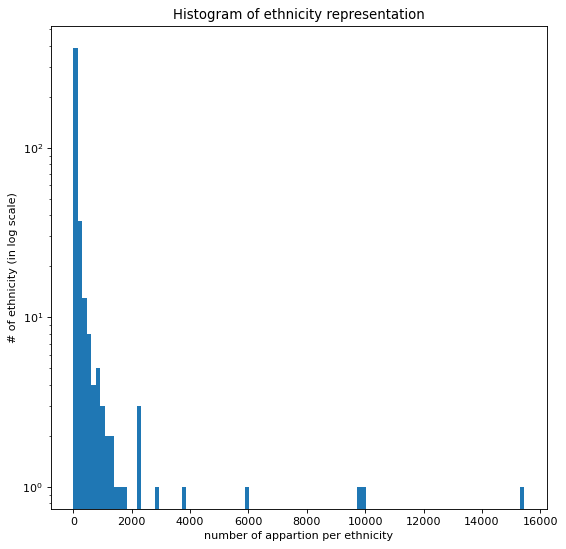

In [4]:
plt.figure(figsize=(8,8), dpi=80)

plt.hist(charac_data['ethnicity'].value_counts().values, bins=100, log = True)[-1]

plt.title('Histogram of ethnicity representation')
plt.ylabel('# of ethnicity (in log scale)')
plt.xlabel('number of appartion per ethnicity')
plt.show()

We can see that a fair proportion of ethnicity are poorly represented. A lot of ethnicity have only a few number of appartion while a few seem to be highly represented. Let's try to vizualise the evolution over the years.

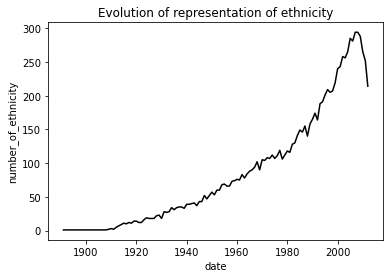

In [5]:
#plot of when ethnicity was finally starred in a movie

date_charac = charac_data.groupby(charac_data['date']).apply(lambda x: pd.Series({
        'num_of_ethnicity': x['ethnicity'].nunique(),
    }))

plt.plot(date_charac.index, date_charac.num_of_ethnicity, color = 'black')

plt.title('Evolution of representation of ethnicity')
plt.ylabel('number_of_ethnicity')
plt.xlabel('date')
plt.show()

We can see that there is a clear evolution of representation of ethnicity over the years. Is it because each country has now the capability to do movies or if there is really an increase of representation. Is there a bias because of more movies are produced each years ? 

### Import data set on movies and merge 

We are also going to use the file `'movie.metadata'` which we are going to merge with the previous dataframe. This new dataframe will contain in addition several more features, like the countries of the movies and the revenue.

In [6]:
data2 = pd.read_csv(data_folder + 'movie.metadata.tsv', sep='\t', header=None)
def format_attr2(df):
     '''
     Create a new dataframe with all attributes
     formatted according to the character data set'
     :param dataframe: pandas.DataFrame
     :return: new dataframe
     '''
     formatted_df = pd.DataFrame()
     formatted_df['wikipedia_id'] = df[df.columns[0]].astype(int)
     formatted_df['movie_name'] = df[df.columns[2]].astype(str)    
     formatted_df['revenue'] = df[df.columns[4]].astype(int, errors='ignore')
     formatted_df['runtime'] = df[df.columns[5]].astype(int, errors='ignore')
     formatted_df['movie_languages'] = df[df.columns[6]].astype(str)
     formatted_df['movie_countries'] = df[df.columns[7]]
     formatted_df['movie_genres'] = df[df.columns[8]].astype(str)
        
     return formatted_df


movie_data = format_attr2(data2)
movie_data.head(10)

,wikipedia_id,movie_name,revenue,runtime,movie_languages,movie_countries,movie_genres
0,975900,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
5,13696889,The Gangsters,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
6,18998739,The Sorcerer's Apprentice,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
7,10408933,Alexander's Ragtime Band,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
8,9997961,Contigo y aquí,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
9,2345652,City of the Dead,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur..."


In [7]:
movie_data = movie_data[movie_data['wikipedia_id'].isin(charac_data['wikipedia_id'])]
merged_data = pd.merge(charac_data, movie_data, left_on='wikipedia_id', right_on='wikipedia_id', how = 'left')
merged_data

,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id,movie_name,revenue,runtime,movie_languages,movie_countries,movie_genres
0,644824,/m/02_1qn,1891.0,nan,M,/m/03lmx1,William Dickson,NaN,/m/0jx879,/m/081ks,nan,Dickson Greeting,NaN,0.05,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0219x_"": ""Indie""}"
1,786716,/m/03c6bq,1894.0,nan,M,/m/03lmx1,William Dickson,NaN,/m/0lqhqw3,/m/081ks,nan,Dickson Experimental Sound Film,NaN,0.00,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film""}"
2,12266752,/m/02vy7q4,1896.0,nan,M,/m/063k3h,William McKinley,NaN,/m/0mzm_t4,/m/083p7,nan,"McKinley at Home, Canton, Ohio",NaN,1.00,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
3,15128774,/m/03hjd3w,1900.0,Prince Hamlet,F,/m/041rx,Sarah Bernhardt,NaN,/m/05x7bw_,/m/0c4qt,/m/0261d9m,Hamlet,NaN,2.00,{},"{""/m/0f8l9c"": ""France""}","{""/m/02hmvc"": ""Short Film"", ""/m/07s9rl0"": ""Dra..."
4,76026,/m/0k2vz,1901.0,nan,M,/m/063k3h,William McKinley,NaN,/m/0lml09m,/m/083p7,nan,President McKinley Inauguration Footage,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102367,30672494,/m/0g9xjv9,2012.0,nan,M,/m/0cqgdq,Rajnikanth,61.0,/m/0gw218j,/m/02wmbg,nan,Rana,NaN,NaN,"{""/m/03k50"": ""Hindi Language"", ""/m/09s02"": ""Te...","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
102368,32985148,/m/0h533hm,2012.0,Raghu,M,/m/0dryh9k,Jiiva,27.0,/m/0h58g5n,/m/0j46lfy,/m/0h8mh95,Neethaane En Ponvasantham,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}",{},"{""/m/02l7c8"": ""Romance Film""}"
102369,23690065,/m/0gxz14q,2012.0,nan,F,/m/01rv7x,Anupama Kumar,37.0,/m/0hzw16b,/m/080kws4,nan,Mugamoodi,NaN,NaN,{},{},"{""/m/04pbhw"": ""Superhero movie""}"
102370,35997584,/m/0j_5r7f,2012.0,nan,M,/m/041rx,Eli Roth,40.0,/m/0mzm4dl,/m/058kqy,nan,Aftershock,NaN,90.00,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}"


Here we get the data merged between character data and movie data.
From this data set, we want to see which country has the most diversity.

Let's try to clean the `movie_countries` feature corresponding to get a clean array.

In [8]:
def map_to_country(row, pick_one=False):
    vals = list(ast.literal_eval(row.movie_countries).values())
    pick_one = False if not vals else pick_one
    return vals if not pick_one else [vals[0]]

df_country = merged_data.copy()
df_country["movie_countries"] = df_country.apply(lambda x: map_to_country(x, False), axis =1)

df_country.sample(10)

,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id,movie_name,revenue,runtime,movie_languages,movie_countries,movie_genres
36531,3948455,/m/0b84rz,1992.0,GR76,M,/m/01qhm_,Ralf Moeller,33.0,/m/0cgcrys,/m/0bt85b,/m/0hh2341,Universal Soldier,102299898.0,84.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/06n90"": ""Science Fiction"", ""/m/0219x_"": ""..."
26640,1031588,/m/03_xh3,1985.0,John,M,/m/02w7gg,Jake Wood,13.0,/m/05nlnyl,/m/09zqt4,/m/05nlnyn,Flesh & Blood,100000.0,128.0,"{""/m/02h40lc"": ""English Language""}","[United States of America, Spain, Netherlands]","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02qvnvs..."
73090,4366275,/m/0bzf73,2005.0,nan,M,/m/04czx7,Mike Tan,18.0,/m/0gcq4qx,/m/0gxdtz,nan,Lovestruck,NaN,111.0,"{""/m/07qv_"": ""Tagalog language""}",[Philippines],"{""/m/06cvj"": ""Romantic comedy"", ""/m/03q4nz"": ""..."
1521,5479998,/m/0dnq12,1932.0,nan,M,/m/0d7wh,Boris Karloff,NaN,/m/0cgnf1h,/m/0hpz8,nan,Murders in the Rue Morgue,NaN,187.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/087lqx"": ""Pre-Code"", ""/m/03npn"": ""Horror""..."
5898,10931425,/m/02qvc18,1951.0,nan,M,/m/04dbw3,Cesar Romero,44.0,/m/03ky4xz,/m/022q4j,nan,Happy Go Lovely,NaN,87.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"{""/m/06cvj"": ""Romantic comedy"", ""/m/04t36"": ""M..."
16400,14878513,/m/03h00vt,1973.0,nan,M,/m/0dryh9k,Sundarrajan,37.0,/m/0jvmqq7,/m/0522m32,nan,Jesus,NaN,NaN,"{""/m/0999q"": ""Malayalam Language""}",[India],"{""/m/01hmnh"": ""Fantasy"", ""/m/07s9rl0"": ""Drama""..."
11369,1334144,/m/04tl2z,1965.0,Maharaja,M,/m/0bpjh3,Utpal Dutt,35.0,/m/0cs4vhy,/m/06gn7r,/m/0h71r1g,Shakespeare Wallah,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",[India],"{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""..."
94169,23002264,/m/064p5bf,2010.0,Adam,M,/m/033tf_,John Cusack,43.0,/m/064zlyg,/m/01gkmx,/m/08nbq2_,Hot Tub Time Machine,61336869.0,98.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...",[United States of America],"{""/m/01q03"": ""Cult"", ""/m/06n90"": ""Science Fict..."
13853,5261530,/m/0dbfgz,1970.0,nan,M,/m/0x67,Robert Hooks,32.0,/m/0jvfgh,/m/068y9r,nan,Carter’s Army,NaN,90.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/03btsm8"": ""Action/Adventure"", ""/m/0c3351""..."
58372,5835745,/m/0f84n0,2001.0,Gilbert Noble,M,/m/07hwkr,Chris Klein,22.0,/m/0k2y9j,/m/03ptnk,/m/0bnlwkv,Say It Isn't So,12320393.0,93.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/06cvj"": ""Romantic comedy"", ""/m/01jw2w"": ""..."


## Representation of Ethnic Diversity in Different Film Industries
### 0 Convert Ethnicity IDs to human-readable words

In [9]:
fname = 'mapping.pickle'
mapping = pickle.load(open(fname,'rb'))

### 1 What are the biggest ethnicities in our dataset?

In [10]:
ethn_by_nActors = charac_data['ethnicity'].value_counts()

ethn = pd.DataFrame()
ethn['ID'] = ethn_by_nActors.keys()
ethn['# Actors'] = ethn_by_nActors.values
ethn['Ethnicity'] = ethn_by_nActors.keys().map(mapping)

For milestone 2, we focus on the 50 most frequent IDs in the dataset. As an example, the top 5 ethnicities are:

In [11]:
ethn.head(10)

,ID,# Actors,Ethnicity
0,/m/0dryh9k,15449,Indians
1,/m/0x67,9983,African Americans
2,/m/041rx,9813,Jewish people
3,/m/02w7gg,5996,English people
4,/m/033tf_,3801,Irish Americans
5,/m/0xnvg,2894,Italian Americans
6,/m/02ctzb,2247,white people
7,/m/07hwkr,2203,white Americans
8,/m/07bch9,2194,Scottish American
9,/m/044038p,1831,False


Since we could not get the ethnicity for `/m/044038p`, we should investigate further for Milestone 3 what the corresponding ethnicity is. Otherwise we would get big errorbars. A short analysis of the corresponding actors makes us to assume that the ethnicity is "Canadian".

In [12]:
No10_mask = ['/m/044038p' in ethnicity for ethnicity in df_country['ethnicity']]
#df_country[No10_mask]

The ethnicities can be clustered in the following ethnic groups:

In [13]:
asian = ['/m/019kn7','/m/01xhh5','/m/03bx0k4','/m/0d2by']
southasian = ['/m/0dryh9k','/m/01rv7x','/m/02sch9','/m/04mvp8','/m/0bpjh3','/m/0cqgdq','/m/09m6hr','/m/0g0x7_','/m/023mqw','/m/0583cz']
black = ['/m/0x67']
latino = ['/m/01g7zj','/m/025rpb0','/m/09k5jvk']
mixed = []
white = ['/m/041rx','/m/02w7gg','/m/033tf_','/m/0xnvg','/m/02ctzb','/m/07hwkr','/m/07bch9','/m/03bkbh','/m/0d7wh','/m/03ts0c','/m/0222qb','/m/03lmx1','/m/065b6q','/m/01qhm_','/m/048z7l','/m/06mvq','/m/0g8_vp','/m/09vc4s','/m/013xrm','/m/06gbnc','/m/07mqps','/m/02g7sp','/m/0g96wd','/m/063k3h','/m/08hpk0','/m/042gtr','/m/09kr66','/m/03ttfc','/m/038723','/m/022dp5','/m/03vv99']
other = []
ethn_groups = {'Asian ex Southasian': asian, 'Southasian': southasian, 'Black/Caribbean/African': black, 'Latino': latino, 'Mixed': mixed, 'White': white, 'Other': other}

The classification was done according to https://www.ethnicity-facts-figures.service.gov.uk/style-guide/ethnic-groups (census UK gov) and https://www.census.gov/newsroom/blogs/random-samplings/2021/08/measuring-racial-ethnic-diversity-2020-census.html (census US gov).

### 2 How are ethnicities represented in the different film industries?

In [14]:
industries = {'US': 'United States of America', 'MX': 'Mexico', 'UK': 'United Kingdom', 'FR': 'France', 'DE': 'Germany', 'IN': 'India', 'HK': 'Hong Kong', 'CN': 'China', 'KR': 'South Korea', 'JP': 'Japan'}
shares = np.zeros((len(industries.keys()),len(ethn_groups.keys())))
i = -1
for country in industries:
    i += 1
    mask = [industries[country] in entry for entry in merged_data['movie_countries']]
    ethnicities_from_country = df_country.loc[mask]['ethnicity'].value_counts()
    j = -1
    for group in ethn_groups:
        j += 1
        count = 0
        for ethnicity in ethn_groups[group]:
            try:
                count += ethnicities_from_country[ethnicity]
            except:
                pass
        shares[i,j] = count

shares_rel = 100*shares/shares.sum(1)[:,None]

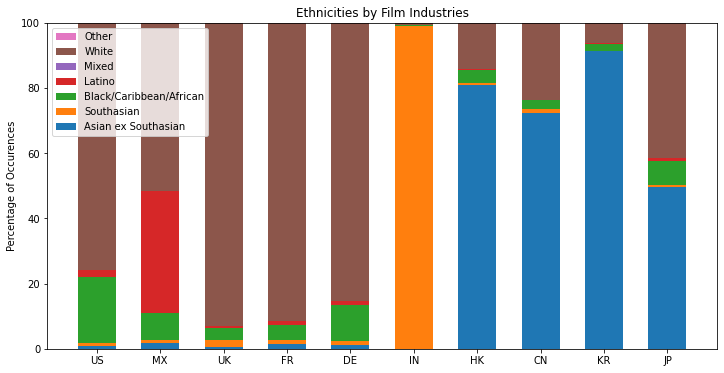

In [15]:
labels = industries.keys()
width = 0.6       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize = (12,6))
ethn_groups_list = list(ethn_groups.keys())
ax.bar(labels, shares_rel[:,0], width, label=ethn_groups_list[0])
bot = 0
for i in range(len(ethn_groups.keys())-1):
    bot += shares_rel[:,i]
    ax.bar(labels, shares_rel[:,i+1], width, bottom=bot, label=ethn_groups_list[i+1])

ax.set_ylabel('Percentage of Occurences')
ax.set_title('Ethnicities by Film Industries')
ax.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[::-1],loc='upper left')

plt.show()

### 3 How did ethnic diversity change over time?

## Diversity of ethnicities and achievement 

Finding what makes an actor effective is necessary to determine whether ethnic diversity and success are related. Using our data, we took into consideration two factors. First, a successful actor has produced a lot of films. Second, a well-paid actor frequently appears in blockbuster films. Of course, this isn't always the case, as some films with excellent box office numbers were not anticipated to be hits, and the actors therefore did not enjoy much success at the time, but they probably gain some success appearing in such movies. 

To take a first glance of our data, we can just look at populars actors and see if their are similary represented for each ethnicity. A popular actor is accessed with an arbitrary threshold first as we define that more than 50 appearences in # movies make an actor successfull. 

In [16]:
#Using the character dataset we want to calculate the number of movies for each actors and filter them for 
top_charac = charac_data.groupby(charac_data['name']).apply(lambda x: pd.Series({
        'ethnicity' : x['ethnicity'].unique()[0],
        'number_of_apparition': len(x['freebase_movie_id'])
    }))

top_charac = top_charac.sort_values(by='number_of_apparition',ascending=False)[top_charac.number_of_apparition > 50]
top_charac

/var/folders/q8/5wnb750d703748h1395pqyr40000gn/T/ipykernel_32484/354307141.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_charac = top_charac.sort_values(by='number_of_apparition',ascending=False)[top_charac.number_of_apparition > 50]


,ethnicity,number_of_apparition
name,,
Mel Blanc,/m/041rx,648
Oliver Hardy,/m/07bch9,298
Mithun Chakraborty,/m/0bpjh3,297
Mohanlal,/m/0dryh9k,223
Mammootty,/m/04mvp8,210
...,...,...
Saif Ali Khan,/m/0bpjh3,51
Bruce Greenwood,/m/044038p,51
Suresh Oberoi,/m/0dryh9k,51


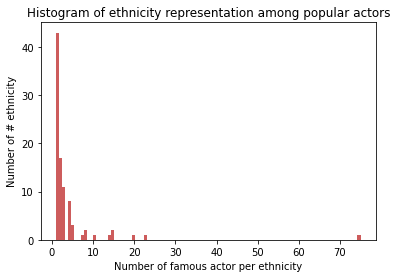

In [17]:
plt.hist(top_charac['ethnicity'].value_counts().values, bins=100,color = 'indianred')[-1]

plt.title('Histogram of ethnicity representation among popular actors')
plt.ylabel('Number of # ethnicity')
plt.xlabel('Number of famous actor per ethnicity')
plt.show()

We can spot several outlier as the plot doesn't look normally distributed but more like an heavy tail distribution. Most ethnicities have little popular actors. A more thorough investigation will yield a more accurate analysis if ethnic diversity is examined at the level of the country. For example it's obvious that United States of America and Monaco are not comparable for their film industry. 

First, there are frequently multiple countries in our dataset of movie and character data. To use it in a document categorization, we must create a new dataset that is organized by country. For each row that has two or more movie countries, we simply expand the number of rows by copying all other information and replacing the nation as a single variable.

In [18]:
# First we make a list of all the countries in the data 
countries = []
for values in df_country['movie_countries'] : 
    for value in values: 
        if value not in countries: 
            countries.append(value) 

# Convert the multiple countries in column in a multiple rows (duplication of the row for each the multiples movie_countries)
dft = df_country.explode('movie_countries')
dft= dft.reset_index()
dft.drop_duplicates(subset='freebase_movie_id', keep='first')


# Analysis movie with the revenue and the number of movies for all countries 
data_countries = pd.DataFrame()

data_countries = merged_data.groupby(dft['movie_countries']).apply(lambda x: pd.Series({
         'revenue' : np.nansum(x['revenue']),
         'number_movie': len(x['freebase_movie_id'])
    }))

# sort data with the most movie at the top
data_c =data_countries.sort_values(by='number_movie',ascending=False)
data_c 

,revenue,number_movie
movie_countries,,
United States of America,1.276953e+12,47938.0
India,4.647530e+11,18827.0
United Kingdom,2.773586e+11,9953.0
France,1.173931e+11,3821.0
Germany,1.144565e+11,3286.0
...,...,...
Burkina Faso,0.000000e+00,1.0
Burma,0.000000e+00,1.0
Cameroon,8.932578e+07,1.0


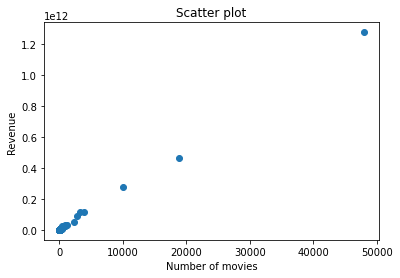

In [19]:
plt.scatter(data_countries['number_movie'], data_countries['revenue'], cmap= 'viridis', label = data_countries.index)
plt.title('Scatter plot')
plt.ylabel('Revenue')
plt.xlabel('Number of movies')
plt.show()

Data visualization highlighting a few key characteristics United States of America, India, and the United Kingdom are a few outliers. Since the revenue is the total of the revenues for each movie the nation made, it is clear that the number of movies and the income are related.

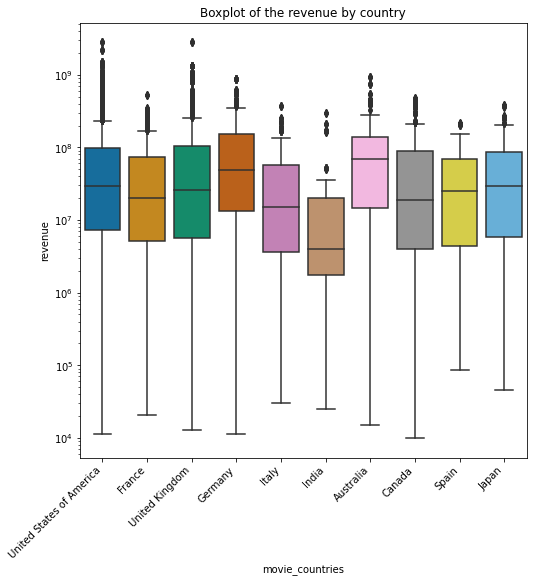

In [20]:
#list of the 10 countries with the largest number of movie
top_10_countries = data_c[:10].index
df = dft[dft['movie_countries'].isin(top_10_countries)]

#Boxplot of the revenue for the 10 top countries 
plt.figure(figsize = (8,8))
ax = sns.boxplot(y = 'revenue', x = 'movie_countries', palette = "colorblind", data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')
ax.set_yscale("log")
_ = plt.title("Boxplot of the revenue by country")

Now that we know which nations are the most significant (and have a sufficient number of movies to work on), we can look at these ten nations in terms of the diversity of performers and their level of success there. Given that there is no representation of Africa, South America, and that half of the countries are European, we could engage with more than just 10 nations to achieve milestone 3. 
First, we'll examine the revenue of films featuring actors of a particular race (ethnic groups as explained earlier)

In [21]:
#create a list with all ethnicities we are interested in
list_ethny = asian + southasian + black + latino + mixed + white + other

In [27]:
#function that create a new column with the categorie of our ethnicity
def filter_ethnicity (value) : 
    
    for row in value['ethnicity'] : 
        categorie =[]
        if (row in asian) : 
            categorie='asian'
        elif (row in white) : 
            categorie='white'
        elif (row in southasian) :
            categorie ='southasian'
        elif (row in black) :
            categorie =' black'
        elif (row in latino) :
            categorie ='latino'
        else :
            categorie ='other'
        
    return categorie

In [28]:
#function for only one country which calculate the average number of movies and revenu for each categorical ethnicity we defined earlier
def ethnic_sucess (country) : 
    
    #filter row for only the country we want
    country_data = df.loc[(df['movie_countries'] == country)]
    
    #filter row for only the ethnicities we want
    country_data = country_data.loc[country_data['ethnicity'].isin(list_ethny)]

    #first we group by actors, there are duplicate because actors play if multiple movies 
    data_actor_succes = country_data.groupby(country_data['ethnicity'], as_index=False).apply(lambda x: pd.Series({
         'average_revenue' : np.nansum(x['revenue'])/len (x['revenue']),
         'number_movie' : len (x['revenue']),
         'categories' : filter_ethnicity(x)
    }))

    return data_actor_succes

IndexError: index 8 is out of bounds for axis 0 with size 8

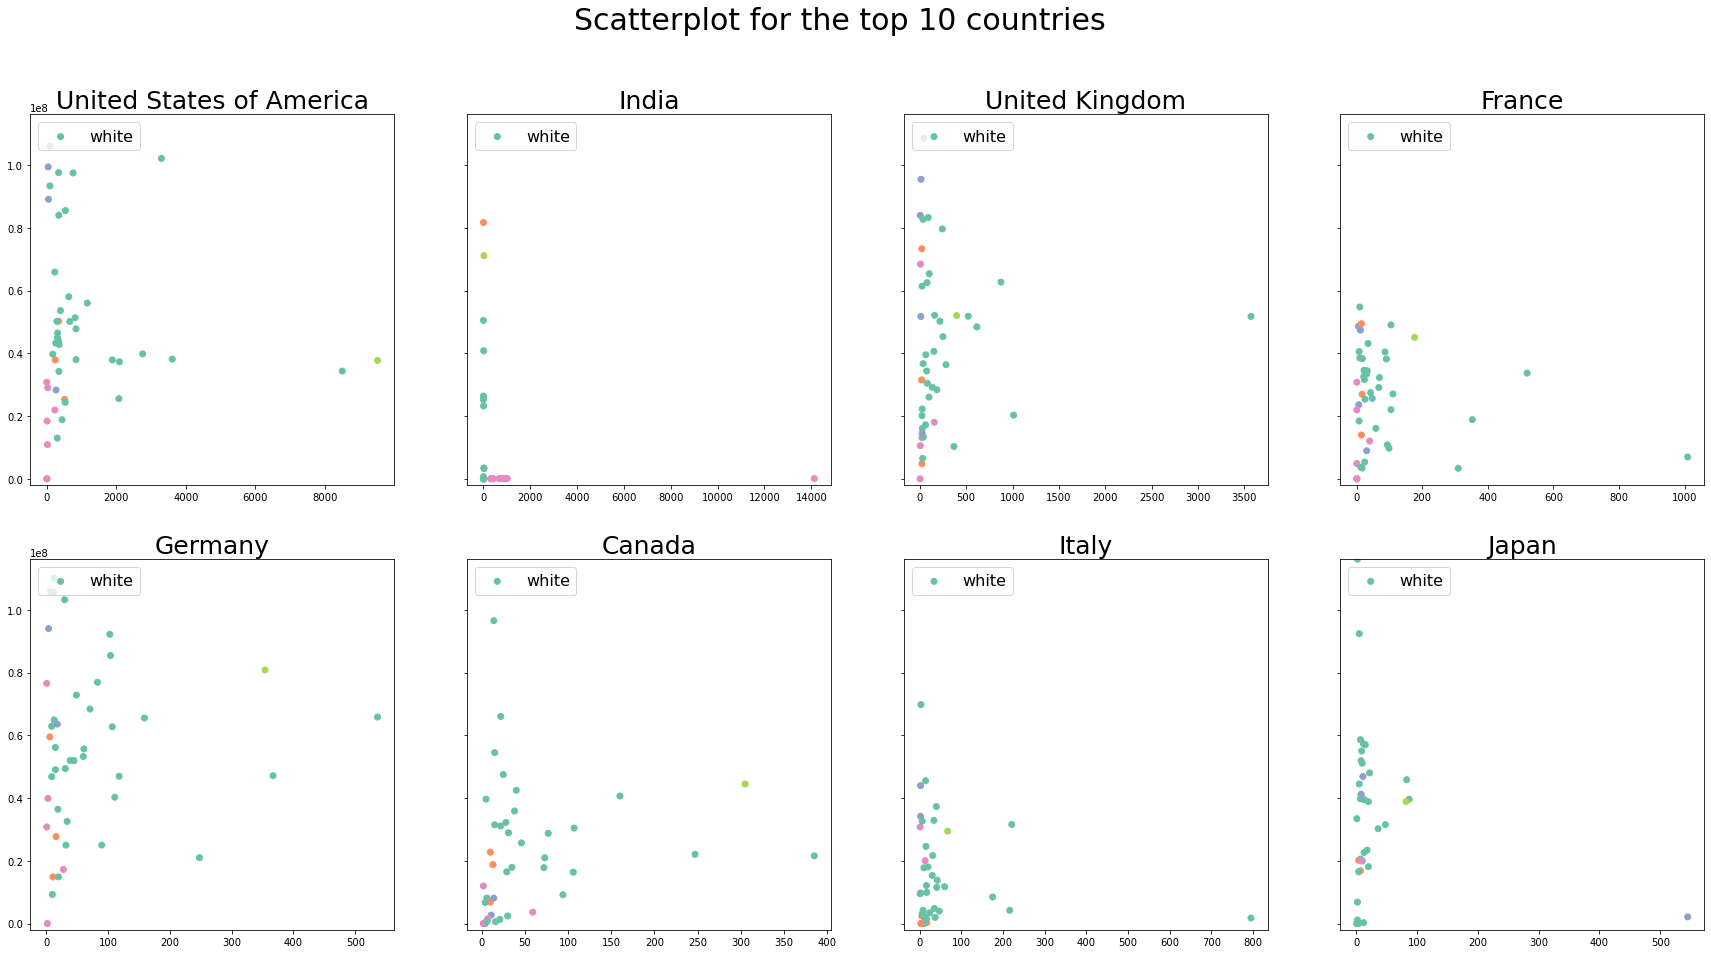

In [64]:
fig, axs = plt.subplots(2,4, figsize=(30, 15), sharey=True)
fig.suptitle('Scatterplot for the top 10 countries', size = 30)
axs = axs.ravel()
# Get Unique ethnicity
color_labels = ethnic_sucess(value)['categories'].unique()

# List of colors in the color palettes
rgb_values = sns.color_palette("Set2", 7)

# Map category to the colors
color_map = dict(zip(color_labels, rgb_values))

# Scatter plot of the average revenue for the 10 top countries 
for i, value in enumerate(top_10_countries) : 
    axs[i].scatter(ethnic_sucess(value)['number_movie'],ethnic_sucess(value)['average_revenue'],c= ethnic_sucess(value)['categories'].map(color_map))
    axs[i].set_title(top_10_countries[i], size = 25)
    axs[i].legend(color_labels,loc='upper left',prop={'size': 16})
    axs[i].yaxis.label.set_size(18)
    axs[i].xaxis.label.set_size(18)
    axs[i].set_ylim(-2000000,np.max(ethnic_sucess(value)['average_revenue']))
for ax in axs.flat:
    ax.set(xlabel='ethnicity', ylabel='average_revenue')
    
fig.delaxes(axs[-1])

It is difficult to identify the cluster since some categories like white has a significant amout of points and other have just one point. However, the same representation may be made without calculating the average box office receipts for each race and normalize for the number of actors ethnicity in each category. We can observe that some nations, like India, have a low level of diversity, but unexpectedly, the ethnicity that produces more films does not always appear in the films that earn the most money. Some data are difficult to understand since we don't know the names of a significant percentage of the ethnic groups that are included in the data.